In [2]:
import pandas as pd
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import matplotlib.pyplot as plt
import lime.lime_tabular

In [3]:
df = pd.read_csv('SBAnational.csv')
df.head()

/home/tteofili/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [4]:
bad_columns = ['LoanNr_ChkDgt', 'NAICS', 'ApprovalDate', 'DisbursementDate', 'Name', 'FranchiseCode']
target = 'MIS_Status'
categorical = ['City', 'State', 'Zip', 'Bank', 'BankState', 'NewExist', 'UrbanRural', 'RevLineCr', 'LowDoc']
ordinal = ['ApprovalFY', 'Term', 'NoEmp', 'CreateJob', 'RetainedJob']
money_columns = ['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']
date_col = ['ChgOffDate']

In [5]:
# drop bad columns
df = df.dropna()
df = df.drop(columns=bad_columns)

In [6]:
# convert date to ordinal days
import datetime as dt
for c in date_col:
    df[c] = pd.to_datetime(df[c]).map(dt.datetime.toordinal)

In [7]:
# encode labels
le = sklearn.preprocessing.LabelEncoder()
df[target] = le.fit_transform(df[target].astype(str))
class_names = le.classes_
print(class_names)

['CHGOFF' 'P I F']


In [8]:
# process ordinal features
for col in ordinal:
    df[col] = pd.to_numeric(df['ApprovalFY'].replace('1976A','1976', regex=False).replace('\d+\-\w+\-\d+|,','', regex=True))
    df[col] = df[col].astype('int32')

In [9]:
# process money columns
for c in money_columns:
    df[c] = df[c].replace('\$|,','', regex=True).replace('\(','-', regex=True).replace('\)','', regex=True)
    df[c] = pd.to_numeric(df[c])

In [10]:
# process categorical features
cat_idxs = [df.columns.get_loc(c) for c in categorical if c in df]
print(cat_idxs)
categorical_names = {}
for c in categorical:
    le = preprocessing.LabelEncoder()
    df[c] = le.fit_transform(df[c])
    categorical_names[c] = le.classes_

[0, 1, 2, 3, 4, 8, 11, 12, 13]


In [11]:
Y = df[target]
X = df.drop(columns=[target])

# Split the data into train and test data:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [12]:
df.head()

,City,State,Zip,Bank,BankState,ApprovalFY,Term,NoEmp,NewExist,CreateJob,...,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
6,13801,31,1398,3393,43,1980,1980,1980,2,1980,...,0,2,3,727007,600000.0,0.0,0,208959.0,600000.0,499998.0
36,6727,35,8859,930,36,1997,1997,1997,1,1997,...,0,2,6,730958,47000.0,0.0,0,14084.0,47000.0,37600.0
43,3773,15,9249,1987,16,1980,1980,1980,2,1980,...,0,5,3,726379,197485.0,0.0,0,44374.0,200000.0,150000.0
58,2311,21,933,3393,43,2006,2006,2006,1,2006,...,1,0,3,735410,1350000.0,0.0,0,1043508.0,1350000.0,1012500.0
60,13187,22,10131,3393,43,1997,1997,1997,1,1997,...,0,0,3,732223,25000.0,0.0,0,23484.0,25000.0,12500.0


In [14]:
lr = LogisticRegression(random_state=1, max_iter=300, penalty="l2", C=0.1)
lr.fit(X_train, Y_train)
sklearn.metrics.accuracy_score(Y_test, lr.predict(X_test))

0.96997668997669

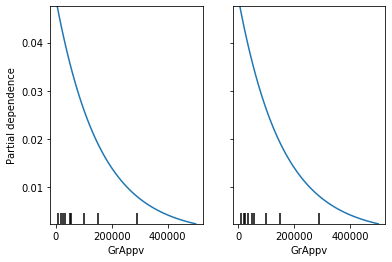

In [15]:
from sklearn.inspection import plot_partial_dependence
features = [18, (18)]
plot_partial_dependence(lr, X_train, features)